# Imperfect Model Experiments: Arctic Sea ice (sic) 850--1850

## Figure 2 and S2
  
Katie Brennan  
August 2020 
  
Experiments drawing observations from the MPI last millennium run at the proxy locations and observations errors drawn from the Pages2kv2 dataset. They were then assimilated into a 200 member prior ensemble drawn from the CCSM4 last millennium run to test this techniqe in a perfect model environment from 850--1850. 

In [1]:
import sys,os,copy

In [2]:
import sys
import numpy as np
import pickle
import xarray as xr

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec

In [3]:
plt.rcParams['figure.dpi']=200

In [4]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [5]:
def load_mpi_lm_regridded():
    mpi_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/MPI/'
    mpi_file = 'mpi_sic_sit_tas_20CRv2_850_1850_full.npz'

    mpi_lm = np.load(mpi_dir+mpi_file)

    mpi_truth_sic = mpi_lm['sic_mpi']
    mpi_truth_sit = mpi_lm['sit_mpi']
    mpi_truth_tas = mpi_lm['tas_mpi']
    mpi_truth_lat = mpi_lm['lat_mpi']
    mpi_truth_lon = mpi_lm['lon_mpi']
    
    return mpi_truth_tas, mpi_truth_sic, mpi_truth_sit, mpi_truth_lat, mpi_truth_lon

In [6]:
def calc_ccsm4_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, ccsm4_truth_time,anom_start, anom_end):
    # NH surface area in M km^2 from concentration in percentage
    nharea = 2*np.pi*(6380**2)/1e8

    sie_lalo_ccsm4 = siutils.calc_sea_ice_extent(ccsm4_truth_sic,15.0)

    _,nh_sic_truth,_ = LMR_utils.global_hemispheric_means(ccsm4_truth_sic,ccsm4_truth_lat[:,0])
    _,nh_sie_truth,_ = LMR_utils.global_hemispheric_means(sie_lalo_ccsm4,ccsm4_truth_lat[:,0])
    sia_ccsm4_truth = nh_sic_truth*nharea
    sie_ccsm4_truth = nh_sie_truth*nharea
    
    anom_int = np.where((ccsm4_truth_time>=anom_start)&(ccsm4_truth_time<anom_end+1))

    sia_ccsm4_truth_anom = sia_ccsm4_truth - np.nanmean(sia_ccsm4_truth[anom_int])
    sie_ccsm4_truth_anom = sie_ccsm4_truth - np.nanmean(sie_ccsm4_truth[anom_int])
    
    return sia_ccsm4_truth, sie_ccsm4_truth, sia_ccsm4_truth_anom, sie_ccsm4_truth_anom

In [7]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    
    ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
#    plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [8]:
def plot_pseudo_tm_validation(ax, time, truth, recon_time, recon, recon_2_5, recon_97_5, 
                              corr_tot, ce_tot, corr_sie_mod, ce_sie_mod, min, max):
    ax.axhline(0,linestyle='--',color='grey')

    ax.plot(time, truth, label='Target (MPI LM)',color='k',linewidth=2)
    ax.plot(recon_time, recon, label = 'Reconstruction (pseudo proxy)',color='royalblue',linewidth=1.0)

    ax.fill_between(recon_time,recon_2_5,recon_97_5,color='royalblue',alpha=0.25)

    ax.set_ylabel('Arctic sea-ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
    ax.set_xlabel('Year (CE)',fontsize=12)
    #plt.title('Total Arctic Sea Ice Extent', fontsize=14)
    
    ax.set_xticks(np.arange(850,1851,100))

    ax.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
    ax.set_ylim(-3,4,1)
    
    ce_corr_plt_ccsm4 = (('(Target, Reconstruction):     R$^2$ = ' + 
                          '{:,.2f}'.format(corr_tot**2))+
                         ', CE = '+'{:,.2f}'.format(ce_tot))
    ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R$^2$ = ' + 
                          '{:,.2f}'.format(corr_sie_mod**2))+
                         ', CE = '+'{:,.2f}'.format(ce_sie_mod))

#     plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
#     plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='royalblue')
#    ax.text(850, -2.0, ce_corr_plt_mod , fontsize=13,color='k')
    ax.text(850, -2.4, ce_corr_plt_ccsm4 , fontsize=13,color='k')

    ax.set_xlim(840,1860)
    ax.set_ylim(min,max)

In [9]:
def calc_lm_tot_si(truth_sic,truth_lat,truth_time,anom_start, anom_end):
    # NH surface area in M km^2 from concentration in percentage
    nharea = 2*np.pi*(6380**2)/1e8

    sie_lalo= calc_sea_ice_extent(truth_sic,15.0)

    _,nh_sic_truth,sh_sic_truth = global_hemispheric_means(truth_sic,truth_lat[:,0])
    _,nh_sie_truth,sh_sie_truth = global_hemispheric_means(sie_lalo,truth_lat[:,0])
    sia_nh_truth = nh_sic_truth*nharea
    sie_nh_truth = nh_sie_truth*nharea
    sia_sh_truth = sh_sic_truth*nharea
    sie_sh_truth = sh_sie_truth*nharea
    
    anom_int = np.where((truth_time>=anom_start)&(truth_time<=anom_end+1))

    sia_nh_truth_anom = sia_nh_truth - np.nanmean(sia_nh_truth[anom_int])
    sie_nh_truth_anom = sie_nh_truth - np.nanmean(sie_nh_truth[anom_int])
    sia_sh_truth_anom = sia_sh_truth - np.nanmean(sia_sh_truth[anom_int])
    sie_sh_truth_anom = sie_sh_truth - np.nanmean(sie_sh_truth[anom_int])
    
    return [sia_nh_truth, sie_nh_truth, sia_nh_truth_anom, sie_nh_truth_anom,
            sia_sh_truth, sie_sh_truth, sia_sh_truth_anom, sie_sh_truth_anom]

In [10]:
def calc_sea_ice_extent(SIC, CUTOFF):
    """Calculates the sea ice extent from concentration values

    SIC = sea ice concentration values (%), full field not anomalies (time,lat,lon)
    CUTOFF = values below this cutoff will be set to zero (%)
    """
    if np.nanmax(SIC)> 1.0:
        sic_nonan = SIC
        sic_nonan[np.isnan(sic_nonan)]=0.0
        sie = np.where(sic_nonan <= CUTOFF,0.0,100)
    elif np.nanmax(SIC) <=1.0:
        sic_nonan = SIC
        sic_nonan[np.isnan(sic_nonan)]=0.0
        sie = np.where(sic_nonan <= CUTOFF/100.0,0.0,1.0)

    return sie

In [11]:
def global_hemispheric_means(field,lat):

    """
     compute global and hemispheric mean valuee for all times in the input (i.e. field) array
     input:  field[ntime,nlat,nlon] or field[nlat,nlon]
             lat[nlat,nlon] in degrees

     output: gm : global mean of "field"
            nhm : northern hemispheric mean of "field"
            shm : southern hemispheric mean of "field"
    """

    # Originator: Greg Hakim
    #             University of Washington
    #             August 2015
    #
    # Modifications:
    #           - Modified to handle presence of missing values (nan) in arrays
    #             in calculation of spatial averages [ R. Tardif, November 2015 ]
    #           - Enhanced flexibility in the handling of missing values
    #             [ R. Tardif, Aug. 2017 ]

    # set number of times, lats, lons; array indices for lat and lon    
    if len(np.shape(field)) == 3: # time is a dimension
        ntime,nlat,nlon = np.shape(field)
        lati = 1
        loni = 2
    else: # only spatial dims
        ntime = 1
        nlat,nlon = np.shape(field)
        field = field[None,:] # add time dim of size 1 for consistent array dims
        lati = 1
        loni = 2

    # latitude weighting 
    lat_weight = np.cos(np.deg2rad(lat))
    tmp = np.ones([nlon,nlat])
    W = np.multiply(lat_weight,tmp).T

    # define hemispheres
    eqind = nlat//2

    if lat[0] > 0:
        # data has NH -> SH format
        W_NH = W[0:eqind+1]
        field_NH = field[:,0:eqind+1,:]
        W_SH = W[eqind+1:]
        field_SH = field[:,eqind+1:,:]
    else:
        # data has SH -> NH format
        W_NH = W[eqind:]
        field_NH = field[:,eqind:,:]
        W_SH = W[0:eqind]
        field_SH = field[:,0:eqind,:]

    gm  = np.zeros(ntime)
    nhm = np.zeros(ntime)
    shm = np.zeros(ntime)

    # Check for valid (non-NAN) values & use numpy average function (includes weighted avg calculation) 
    # Get arrays indices of valid values
    indok    = np.isfinite(field)
    indok_nh = np.isfinite(field_NH)
    indok_sh = np.isfinite(field_SH)
    for t in range(ntime):
        if lati == 0:
            # Global
            gm[t]  = np.average(field[indok],weights=W[indok])
            # NH
            nhm[t] = np.average(field_NH[indok_nh],weights=W_NH[indok_nh])
            # SH
            shm[t] = np.average(field_SH[indok_sh],weights=W_SH[indok_sh])
        else:
            # Global
            indok_2d    = indok[t,:,:]
            if indok_2d.any():
                field_2d    = np.squeeze(field[t,:,:])
                gm[t]       = np.average(field_2d[indok_2d],weights=W[indok_2d])
            else:
                gm[t] = np.nan
            # NH
            indok_nh_2d = indok_nh[t,:,:]
            if indok_nh_2d.any():
                field_nh_2d = np.squeeze(field_NH[t,:,:])
                nhm[t]      = np.average(field_nh_2d[indok_nh_2d],weights=W_NH[indok_nh_2d])
            else:
                nhm[t] = np.nan
            # SH
            indok_sh_2d = indok_sh[t,:,:]
            if indok_sh_2d.any():
                field_sh_2d = np.squeeze(field_SH[t,:,:])
                shm[t]      = np.average(field_sh_2d[indok_sh_2d],weights=W_SH[indok_sh_2d])
            else:
                shm[t] = np.nan

    return gm,nhm,shm

In [12]:
def find_ce_corr(VAR, REF, REF_TIME, VAR_TIME, START_TIME, END_TIME, detrend=False):
    """Finds the correlation coefficient and coefficient of efficiency between 
       REF and VAR between START_TIME and END_TIME.
       inputs: 
           VAR = test data (1D in time)
           REF = reference data (1D in time) 
           REF_time = reference data time (1D time)
           VAR_TIME = test data time (1D years)
           START_TIME = comparison start year to be included (float)
           END_TIME = last year included in comparison (float)
       
    """
    yr_range_var = np.where((VAR_TIME>=START_TIME)&(VAR_TIME<END_TIME+1))
    yr_range_ref = np.where((REF_TIME>=START_TIME)&(REF_TIME<END_TIME+1))
    
    if detrend is False: 
        ref = REF[yr_range_ref[0]]
        var = VAR[yr_range_var[0]]
    else: 
        ref = spy.detrend(REF[yr_range_ref])
        var = spy.detrend(VAR[yr_range_var])
        
    ce = coefficient_efficiency(ref,var)
    corr = np.corrcoef(ref,var)[0,1]
    var_ref = np.var(ref)
    var_var = np.var(var)
    
    return ce, corr,var_ref,var_var

In [13]:
def coefficient_efficiency(ref,test,valid=None):
    """
    ***Copied from LMR_utils.py 04/08/20***
    Compute the coefficient of efficiency for a test time series, 
    with respect to a reference time series.

    Inputs:
    test:  test array
    ref:   reference array, of same size as test
    valid: fraction of valid data required to calculate the statistic 

    Note: Assumes that the first dimension in test and ref arrays is time!!!

    Outputs:
    CE: CE statistic calculated following Nash & Sutcliffe (1970)
    """

    # check array dimensions
    dims_test = test.shape
    dims_ref  = ref.shape
    #print('dims_test: ', dims_test, ' dims_ref: ', dims_ref)

    if len(dims_ref) == 3:   # 3D: time + 2D spatial
        dims = dims_ref[1:3]
    elif len(dims_ref) == 2: # 2D: time + 1D spatial
        dims = dims_ref[1:2]
    elif len(dims_ref) == 1: # 0D: time series
        dims = 1
    else:
        print('In coefficient_efficiency(): Problem with input array dimension! Exiting...')
        SystemExit(1)

    CE = np.zeros(dims)

    # error
    error = test - ref

    # CE
    numer = np.nansum(np.power(error,2),axis=0)
    denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
    CE    = 1. - np.divide(numer,denom)

    if valid:
        nbok  = np.sum(np.isfinite(ref),axis=0)
        nball = float(dims_ref[0])
        ratio = np.divide(nbok,nball)
        indok  = np.where(ratio >= valid)
        indbad = np.where(ratio < valid)
        dim_indbad = len(indbad)
        testlist = [indbad[k].size for k in range(dim_indbad)]
        if not all(v == 0 for v in testlist):
            if isinstance(dims,(tuple,list)):
                CE[indbad] = np.nan
            else:
                CE = np.nan

    return CE

In [14]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

### Load Last Millennium 'truth' simulation: 

In [15]:
recon_start = 850
recon_end = 1849

In [16]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

[sia_nh_ccsm4_truth, sie_nh_ccsm4_truth, 
 sia_nh_ccsm4_truth_anom, sie_nh_ccsm4_truth_anom,
 sia_sh_ccsm4_truth, sie_sh_ccsm4_truth, 
 sia_sh_ccsm4_truth_anom, 
 sie_sh_ccsm4_truth_anom] = calc_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                           ccsm4_truth_time, recon_start, recon_end)

In [17]:
[mpi_truth_tas, mpi_truth_sic, 
 mpi_truth_sit,
 mpi_truth_lat, mpi_truth_lon] = load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

[sia_nh_mpi, sie_nh_mpi, 
 sia_nh_mpi_anom, sie_nh_mpi_anom,
 sia_sh_mpi, sie_sh_mpi, 
 sia_sh_mpi_anom, sie_sh_mpi_anom] = calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                    mpi_time, recon_start, recon_end)

In [18]:
it_ccsm4 = np.where(ccsm4_truth_time>=recon_start)
it_mpi = np.where(mpi_time>=recon_start)
 
sia_nh_ccsm4_truth_anom = sia_nh_ccsm4_truth_anom[it_ccsm4]
sie_nh_ccsm4_truth_anom = sie_nh_ccsm4_truth_anom[it_ccsm4]
sia_sh_ccsm4_truth_anom = sia_sh_ccsm4_truth_anom[it_ccsm4]
sie_sh_ccsm4_truth_anom = sie_sh_ccsm4_truth_anom[it_ccsm4]

sia_nh_mpi_anom = sia_nh_mpi_anom[it_mpi]
sie_nh_mpi_anom = sie_nh_mpi_anom[it_mpi]
sia_sh_mpi_anom = sia_sh_mpi_anom[it_mpi]
sie_sh_mpi_anom = sie_sh_mpi_anom[it_mpi]

In [19]:
[ce_sie_mod,
 corr_sie_mod,_,_] = find_ce_corr(sie_nh_ccsm4_truth_anom, 
                                  sie_nh_mpi_anom,
                                  mpi_time[it_mpi],
                                  ccsm4_truth_time[it_ccsm4],
                                  recon_start, recon_end)

corr_sie_mod**2,ce_sie_mod

(0.035515127251206355, -0.5414335155330279)

## Figure S2: 

In [20]:
mpi_sic_spatialmn = np.nanmean(mpi_truth_sic,axis=0)
ccsm4_sic_spatialmn = np.nanmean(ccsm4_truth_sic,axis=0)

lm_diff = ccsm4_sic_spatialmn - mpi_sic_spatialmn

lm_diff_plot = np.where(np.abs(lm_diff)<0.05,np.nan,lm_diff)

/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


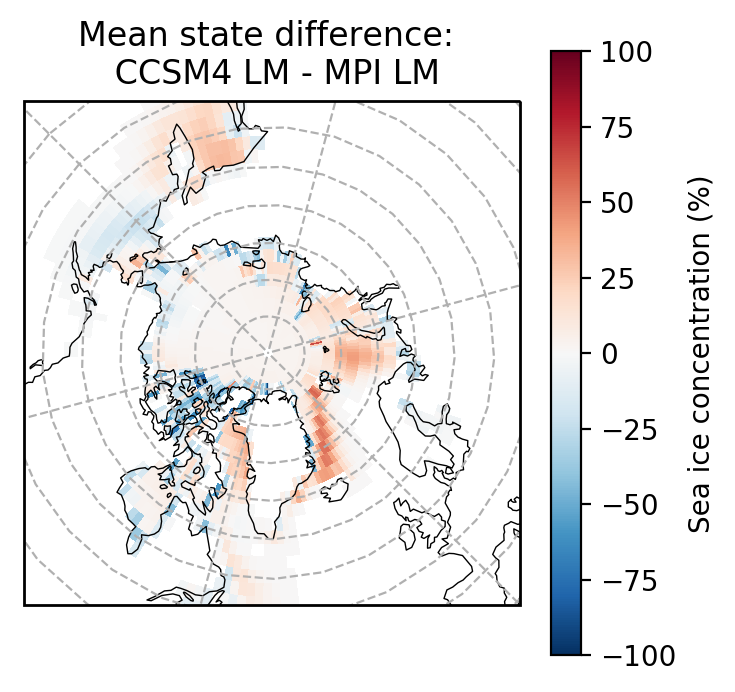

In [21]:
fig,ax = plt.subplots(1,1, figsize=(4, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax,lm_diff_plot,
                     ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Mean state difference: \n CCSM4 LM - MPI LM',100)

plt.colorbar(cs,ax=ax,label='Sea ice concentration (%)')

#fig.suptitle('Last Millennium simulations mean state difference', fontsize=14,x=0.43)
#plt.tight_layout(rect=(0,0.05,0.92,0.94))

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'CCSM4_minus_MPI_LM_mean_state_diff.png'
#plt.savefig(savedir+savename)

### Load psedo experiments, R = Pages2kv2 values: 

In [22]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file = 'Brennan_and_Hakim_2021_imperfect_pseudo_experiment_nh.nc'

recon_data = xr.open_dataset(recon_dir+recon_file)

sie_ccsm4_recon_anom = recon_data.si_extent_ensemble_mean_anomalies.values

sie_recon_97_5_anom = recon_data.si_extent_97_5_percentiles.values
sie_recon_2_5_anom = recon_data.si_extent_2_5_percentiles.values

recon_years = recon_data.time.values

## Northern Hemisphere skill: 

In [30]:
sie_recon_97_5_anom = recon_data.si_extent_97_5_percentiles.values
sie_recon_2_5_anom = recon_data.si_extent_2_5_percentiles.values

sie_ens_anom_allit = recon_data.si_extent_anomalies.values
sie_ccsm4_recon_anom = recon_data.si_extent_ensemble_mean_anomalies.values

In [31]:
yr = 850
[ce_tot,corr_tot,_,_] = find_ce_corr(sie_ccsm4_recon_anom,
                                     sie_nh_mpi_anom, 
                                     mpi_time[it_mpi],
                                     np.array(recon_years),
                                     yr,1849)

print('CE (850-1850) = '+str(ce_tot))
print('R^2 (850-1850) = '+str(corr_tot**2))

CE (850-1850) = 0.4333869844389574
R^2 (850-1850) = 0.4344480655920037


In [32]:
seg_length =500
ce_sie_pseudo = []
corr_sie_pseudo = []

for yr in range(recon_years[0],recon_years[-1]-seg_length+1): 
#    print(str(yr))
    [ce_seg,
     corr_seg,_,_] = find_ce_corr(sie_ccsm4_recon_anom,
                                  sie_nh_mpi_anom,
                                  mpi_time[it_mpi],
                                  np.array(recon_years),
                                  yr,yr+seg_length)

    ce_sie_pseudo = np.append(ce_sie_pseudo,ce_seg)
    corr_sie_pseudo = np.append(corr_sie_pseudo,corr_seg)

#### Load proxy locations for plotting: 

In [33]:
proxinfo_loc = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/'+
            'experiments/pseudo/pages2kv2_all_proxy_info.pkl')

prox_loc_info = pickle.load(open(proxinfo_loc,'rb'))

In [34]:
proxy_types = ['Tree Rings_WidthPages2', 'Tree Rings_WoodDensity', 
               'Ice Cores_d18O', 'Ice Cores_dD', 
               'Ice Cores_MeltFeature', 'Lake Cores_Varve',
               'Lake Cores_Misc']

### Spatial validation: SIC

In [38]:
(mpi_truth_lat>0).sum()

8280

In [40]:
sic_shape = recon_data.sic_lalo_ensemble_mean.values.shape
sic_shape_true = mpi_truth_sic.shape

sic_lalo_ensmn = recon_data.sic_lalo_ensemble_mean.values
sic_truth_lalo = np.squeeze(mpi_truth_sic[it_mpi,:,:])

sic_recon_2d = np.reshape(sic_lalo_ensmn,(sic_shape[0],sic_shape[1]*sic_shape[2]))
# sic_truth_2d = np.reshape(mpi_truth_sic,(sic_shape_true[0],sic_shape_true[1]*sic_shape_true[2]))
# sic_truth_2d = np.squeeze(sic_truth_2d[it_mpi,:])

sic_truth_2d = sic_truth_lalo[:,(mpi_truth_lat>0)]

In [41]:
sic_recon_2d_anom = sic_recon_2d - np.nanmean(sic_recon_2d,axis=0)
sic_truth_2d_anom = sic_truth_2d - np.nanmean(sic_truth_2d,axis=0)

In [44]:
r_sic_anom = np.zeros(sic_truth_2d.shape[1])
ce_sic_anom = np.zeros(sic_truth_2d.shape[1])

for lalo in range(sic_truth_2d.shape[1]):
    r_sic_anom[lalo] = np.corrcoef(sic_truth_2d_anom[:,lalo],sic_recon_2d_anom[:,lalo])[0,1]
    ce_sic_anom[lalo]= coefficient_efficiency(sic_truth_2d_anom[:,lalo],sic_recon_2d_anom[:,lalo])
    
r_sic_anom = np.reshape(r_sic_anom,(sic_shape[1],sic_shape[2]))
ce_sic_anom = np.reshape(ce_sic_anom,(sic_shape[1],sic_shape[2]))

/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


# Figure 2: 

/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/home/disk/chaos/mkb22/anaconda2/envs/lims/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


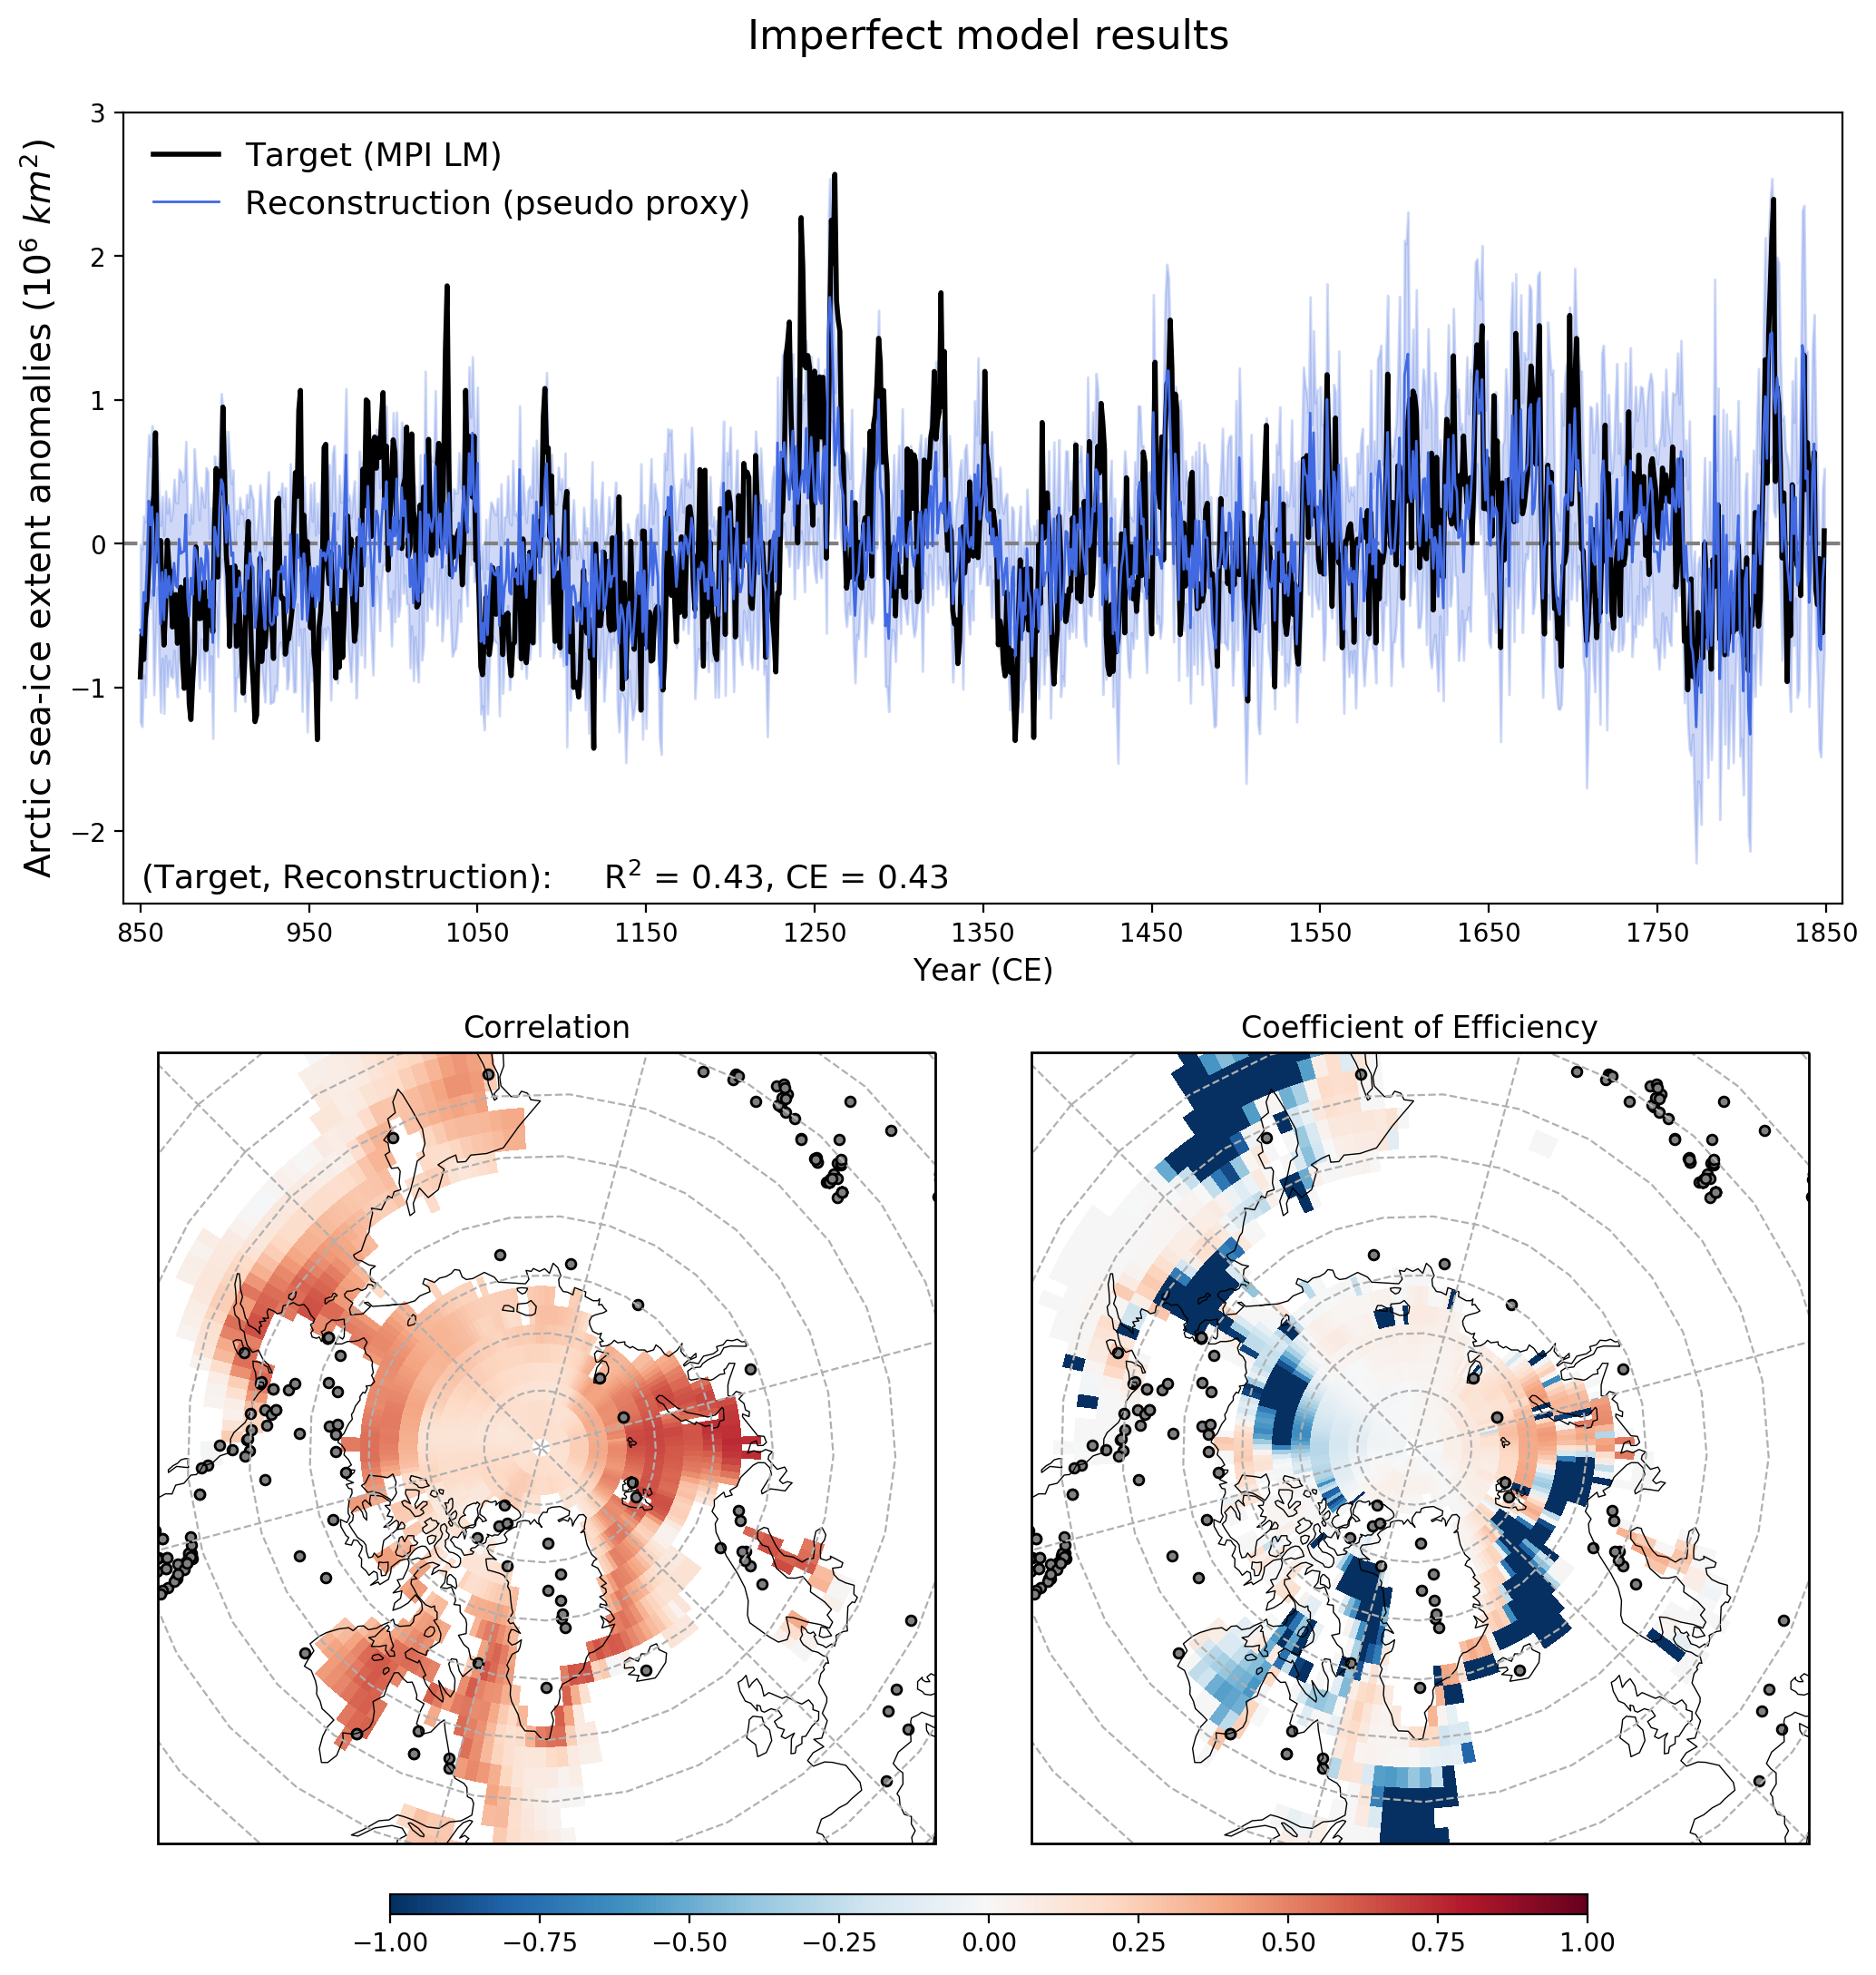

In [46]:
fig= plt.figure(figsize=(11, 11))

gs = gridspec.GridSpec(2,2, figure=fig)

ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[-1, 0], projection = ccrs.Stereographic(central_latitude=90,
                                                                 central_longitude=-45,
                                                                 true_scale_latitude=0.1))
ax2 = fig.add_subplot(gs[-1, -1], projection = ccrs.Stereographic(central_latitude=90,
                                                                 central_longitude=-45,
                                                                 true_scale_latitude=0.1))

plot_pseudo_tm_validation(ax0, mpi_time[it_mpi],sie_nh_mpi_anom, recon_years,sie_ccsm4_recon_anom, 
                          sie_recon_2_5_anom,sie_recon_97_5_anom,corr_tot, ce_tot, 
                          corr_sie_mod, ce_sie_mod, -2.5,3)

cs = sub_arctic_plot(fig,ax1,r_sic_anom,recon_data.lat.values,
                         recon_data.lon.values,'Correlation',1)
cs = sub_arctic_plot(fig,ax2,ce_sic_anom,recon_data.lat.values,
                         recon_data.lon.values,'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax1.scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax2.scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax0.get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
        
# plt.colorbar(cs,ax=ax2)
position=fig.add_axes([0.2,0.03,0.6,0.01])
cb = plt.colorbar(cs, cax=position, orientation='horizontal')

fig.suptitle('Imperfect model results',fontsize=16)

plt.tight_layout(rect=(0,0.05,0.95,0.96))
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_sis_arctic_sic_anom_space_temp_performance_recon_850_1850_truth_r_CE.png'
plt.savefig(savedir+savename)